![Transformer](transformer.png)

# Prepare data

In [1]:
document_text = open("data/shakespeare.txt", 'r', encoding='utf-8').read()
print(f"length of data text: {len(document_text)}")

length of data text: 1115394


In [2]:
print(document_text[:30])

First Citizen:
Before we proce


In [4]:
vocab = sorted(list(set(document_text)))
vocab_size = len(vocab)
vocab_size

65

In [7]:
letter2index = {l:i for i, l in enumerate(vocab)}
index2letter = {i: l for l, i in letter2index.items()}

In [8]:
encode = lambda sentence: [letter2index[l] for l in sentence]
decode = lambda indices: ''.join([index2letter[i] for i in indices])

In [9]:
print(encode("Hello world!"))
print(decode(encode("Hello world!")))

[20, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 2]
Hello world!


In [10]:
import torch

In [11]:
data = torch.tensor(encode(document_text), dtype=torch.long)
print(data.shape, data.dtype)
data[:20]

torch.Size([1115394]) torch.int64


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56])

In [12]:
split_n = int(0.9 * len(data))
train_data = data[:split_n]
val_data = data[split_n:]
print(train_data.shape, val_data.shape)

torch.Size([1003854]) torch.Size([111540])


In [16]:
def get_dataset(split_name):
    return train_data if split_name == 'train' else val_data

In [13]:
context_len = 8

In [14]:
train_data[:context_len + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [15]:
x = train_data[:context_len]
y = train_data[1:context_len+1]
for t in range(context_len):
    context = x[:t+1]
    target = y[t]
    print(f"context: {context} -> target: {target}")

context: tensor([18]) -> target: 47
context: tensor([18, 47]) -> target: 56
context: tensor([18, 47, 56]) -> target: 57
context: tensor([18, 47, 56, 57]) -> target: 58
context: tensor([18, 47, 56, 57, 58]) -> target: 1
context: tensor([18, 47, 56, 57, 58,  1]) -> target: 15
context: tensor([18, 47, 56, 57, 58,  1, 15]) -> target: 47
context: tensor([18, 47, 56, 57, 58,  1, 15, 47]) -> target: 58


In [18]:
torch.randint(len(train_data) - context_len, (4, ))

tensor([614385, 849221, 278078, 785208])

In [20]:
def get_batch(dataset, batch_size, context_len):
    ix = torch.randint(len(dataset) - context_len, (batch_size, ))
    x = torch.stack([dataset[i:i+context_len] for i in ix])
    y = torch.stack([dataset[i+1:context_len+i+1] for i in ix])
    return x, y

In [21]:
xb, yb = get_batch(get_dataset('train'), batch_size=4, context_len=8)
print(f"Inputs: {xb.shape}")
print(xb)
print(f"Ouputs: {yb.shape}")
print(yb)

Inputs: torch.Size([4, 8])
tensor([[54, 43, 41, 58, 47, 60, 43,  1],
        [63, 43, 58,  2,  0, 35, 46, 43],
        [54,  1, 47, 58,  1, 52, 53, 61],
        [63,  6,  1, 57, 54, 43, 39, 49]])
Ouputs: torch.Size([4, 8])
tensor([[43, 41, 58, 47, 60, 43,  1, 40],
        [43, 58,  2,  0, 35, 46, 43, 56],
        [ 1, 47, 58,  1, 52, 53, 61,  6],
        [ 6,  1, 57, 54, 43, 39, 49,  1]])


# Simple bigram model

In [29]:
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, targets=None):
        logits = self.token_embedding(x) # (B, T, C)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits_v = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits_v, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx: (B, T)
        for _ in range(max_new_tokens):
            logits, _ = self(idx) # logits: (B, T, C)
            logits = logits[:, -1, :] # the last token (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) #(B, 1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


model = BigramLanguageModel(vocab_size)
output, loss = model(xb, yb)
print(output.shape, loss.shape)

torch.Size([4, 8, 65]) torch.Size([])


In [30]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=20)[0].tolist()))


SKIcLT;AcELMoTbvZv C


In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

train_set = get_dataset('train')
batch_size = 32

losses = []

for step in range(10000):
    xb, yb = get_batch(train_set, batch_size, context_len)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

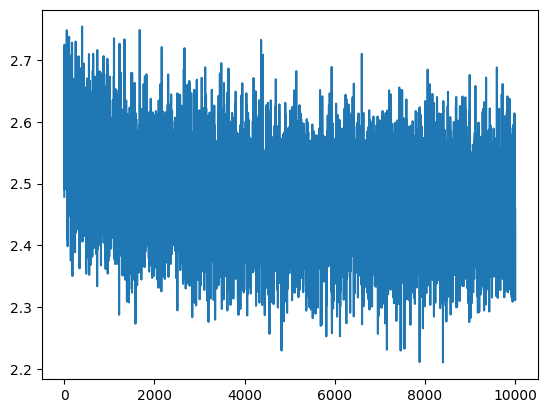

In [49]:
plt.plot(losses)

In [51]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))


Pasend devibathe pe tulaitowitt,
ICIn witere at?
obl,
Tharul y ou s s t pordel be
Whay st ILI s Ithe


# Implement GPT

```
Attention is All you need!
```

![Attention is All you need](attention-paper.png)

In [54]:
@torch.no_grad()
def estimate_loss(model, eval_iters, batch_size, context_len):
    outputs = {}
    model.eval()

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(get_dataset(split), batch_size, context_len)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        outputs[split] = losses.mean()
    
    model.train()
    return outputs

In [55]:
estimate_loss(model, 20, batch_size, context_len)

{'train': tensor(2.4692), 'val': tensor(2.4767)}

## Self Attention

In [56]:
torch.manual_seed(1337)

B, T, C = 4, 8, 2 # (batch, time, channel)
x = torch.randn((B, T, C))
x.shape

torch.Size([4, 8, 2])

### bag-of-word: average of previous tokens

In [62]:
xbow = torch.zeros((B, T, C))
for t in range(T):
    xprev = x[:, :t+1, :] # (B, t, C)
    xbow[:, t, :] = xprev.mean(dim=1, keepdim=True).squeeze(1)

In [63]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [64]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [68]:
print(x[0][:2].mean(dim=0, keepdim=True), xbow[0][1])
print(x[0][:3].mean(dim=0, keepdim=True), xbow[0][2])
print(x[0][:4].mean(dim=0, keepdim=True), xbow[0][3])

tensor([[-0.0894, -0.4926]]) tensor([-0.0894, -0.4926])
tensor([[ 0.1490, -0.3199]]) tensor([ 0.1490, -0.3199])
tensor([[ 0.3504, -0.2238]]) tensor([ 0.3504, -0.2238])


In [76]:
a = torch.tril(torch.ones(3, 3))
a /= a.sum(dim=1, keepdim=True)
b = torch.randint(10, (3, 2)).float()
c = a @ b
print("a:", a)
print("b:", b)
print("c:", c)


a: tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b: tensor([[4., 9.],
        [5., 3.],
        [5., 6.]])
c: tensor([[4.0000, 9.0000],
        [4.5000, 6.0000],
        [4.6667, 6.0000]])


In [79]:
a = torch.tril(torch.ones(T, T))
a /= a.sum(dim=1, keepdim=True)
(a @ x).shape # (T, T) @ (B, T, C) broadcasting: (B, T, T) @ (B, T, C) -> (B, T, C)

torch.Size([4, 8, 2])

In [80]:
torch.allclose(xbow, (a @ x))

True

In [81]:
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [82]:
wei = torch.zeros((T, T))
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [83]:
wei = wei.masked_fill(tril == 0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [84]:
wei = F.softmax(wei, dim=1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [86]:
(wei @ x)[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [134]:
head_size = 16

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k, q = key(x), query(x) # (B, T, head_size)
wei = q @ k.transpose(-2, -1) # (B, T, H) @ (B, H, T) -> (B, T, T)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
# output = wei @ x
v = value(x)
output = wei @ v

output.shape

torch.Size([4, 8, 16])

In [132]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7323, 0.2677, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3445, 0.2697, 0.3857, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2370, 0.1686, 0.2799, 0.3145, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1552, 0.5852, 0.1242, 0.1104, 0.0250, 0.0000, 0.0000, 0.0000],
        [0.1545, 0.1467, 0.1356, 0.1221, 0.2070, 0.2341, 0.0000, 0.0000],
        [0.1383, 0.0918, 0.1536, 0.1639, 0.2296, 0.0923, 0.1306, 0.0000],
        [0.0432, 0.4633, 0.0246, 0.0175, 0.0021, 0.3854, 0.0614, 0.0024]],
       grad_fn=<SelectBackward0>)

In [195]:
class AttnHead(nn.Module):

    def __init__(self, embedding_size, head_size, context_len, dropout_p) -> None:
        super().__init__()

        self.key = nn.Linear(embedding_size, head_size, bias=False)
        self.query = nn.Linear(embedding_size, head_size, bias=False)
        self.value = nn.Linear(embedding_size, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(context_len, context_len)))
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, H) @ (B, H, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1) # B, T, T
        wei = self.dropout(wei)

        output = wei @ v # (B, T, T) @ (B, T, H) -> (B, T, H)
        return output



class MultiHeadAttn(nn.Module):

    def __init__(self, embedding_size, head_size, context_len, num_heads, dropout_p) -> None:
        super().__init__()

        self.heads = nn.ModuleList([
            AttnHead(embedding_size=embedding_size, head_size=head_size, context_len=context_len,dropout_p=dropout_p)
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear(head_size * num_heads, head_size * num_heads)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = torch.cat([attn(x) for attn in self.heads], dim=-1)
        x = self.dropout(self.proj(x))
        return x
    

class FeedForward(nn.Module):

    def __init__(self, embedding_size, dropout_p) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(embedding_size, 4 * embedding_size),
            nn.ReLU(),
            nn.Linear(4 * embedding_size, embedding_size),
            nn.Dropout(dropout_p)
        )

    def forward(self, x):
        return self.net(x)

In [196]:
class AttnBlock(nn.Module):

    def __init__(self, embedding_size, context_len, num_heads, dropout_p) -> None:
        super().__init__()

        self.satt_head = MultiHeadAttn(
            embedding_size=embedding_size,
            head_size=embedding_size//num_heads,
            context_len=context_len,
            num_heads=num_heads,
            dropout_p=dropout_p
        )

        self.ffwd = FeedForward(embedding_size=embedding_size, dropout_p=dropout_p)
        self.ln1 = nn.LayerNorm(embedding_size)
        self.ln2 = nn.LayerNorm(embedding_size)

    def forward(self, x):
        x = x + self.satt_head(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [197]:
class CharModel(nn.Module):

    def __init__(self, vocab_size, embedding_size, context_len, n_layers, num_heads, dropout_p) -> None:
        super().__init__()

        self.token_embedding_model = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding_model = nn.Embedding(context_len, embedding_size)

        self.blocks = nn.Sequential(*[
            AttnBlock(embedding_size=embedding_size, context_len=context_len, num_heads=num_heads, dropout_p=dropout_p)
            for _ in range(n_layers)
        ])

        self.ln = nn.LayerNorm(embedding_size)
        self.lm_head = nn.Linear(embedding_size, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_model(idx) # (B, T, embedding_size)
        pos_emb = self.position_embedding_model(torch.arange(T)) # (T, C)

        embedded = tok_emb + pos_emb # broadcast of batch dim: (B, T, C)
        embedded = self.blocks(embedded)
        embedded = self.ln(embedded)
        logits = self.lm_head(embedded) # (B, T, vocab_size)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits_v = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits_v, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx: (B, T)
        T = self.position_embedding_model.num_embeddings
        for _ in range(max_new_tokens):
            input_idx = idx[:, -T:]
            logits, _ = self(input_idx) # logits: (B, T, C)
            logits = logits[:, -1, :] # the last token (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) #(B, 1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [198]:
def train(model, n_steps):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    train_set = get_dataset('train')
    batch_size = 32

    losses = []

    for _ in range(n_steps):
        xb, yb = get_batch(train_set, batch_size, context_len)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return model, losses

In [199]:
embedding_size = 32
n_head = 4
n_layers = 3

model = CharModel(vocab_size=vocab_size, embedding_size=embedding_size, context_len=context_len, n_layers=n_layers, num_heads=n_head, dropout_p=0.1)
print(context_len)
model, losses = train(model, 5000)

8


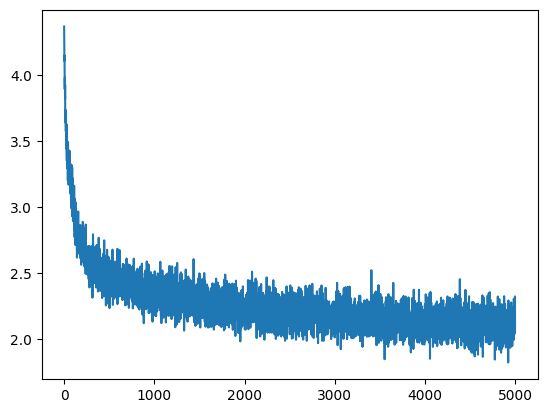

In [200]:
plt.plot(losses)

In [201]:
estimate_loss(model, 20, batch_size, context_len)

{'train': tensor(2.0136), 'val': tensor(2.1280)}

In [202]:
idx = torch.zeros((1, context_len), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))









CEGARKE:
MINE Burchery.

Wmorre home,
Shee pothen cewemch he wead shing; I same
Ont thore;

As ambry
